# Importing dataset

In [ ]:
import zipfile
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from keras.models import Sequential
from keras import layers
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation,GlobalMaxPooling2D
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.models import Model
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [ ]:
# Menyambungkan ke GDrive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
local_zip = '/content/gdrive/MyDrive/datasets_4.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content/dataset')
zip_ref.close()

In [ ]:
os.chdir('/content/dataset')
base_url = '/content/dataset/datasets_4/content/datasets'

# Preprocessing

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale = 1./255., 
                             rotation_range = 40, 
                             horizontal_flip = True, 
                             validation_split=0.3,
                             fill_mode = 'nearest')

# train_datagen = ImageDataGenerator(rescale = 1./255., rotation_range = 40, horizontal_flip = True, validation_split=0.3)
# validation_datagen = ImageDataGenerator(rescale = 1.0/255.)

train_generator = datagen.flow_from_directory(
        base_url,
        classes = ['Chocolate Cake', 'Pasta', 'Pizza', 'Salad'],
        target_size=(128, 128),
        subset='training',
        batch_size=32,
        class_mode='categorical')

validation_generator = datagen.flow_from_directory(
        base_url,
        classes = ['Chocolate Cake', 'Pasta', 'Pizza', 'Salad'],
        target_size=(128, 128),
        subset='validation',
        batch_size=32,
        class_mode='categorical',
        shuffle=False)

Found 559 images belonging to 4 classes.
Found 239 images belonging to 4 classes.


# VGG16

In [ ]:

image_size = 128
input_shape = (image_size, image_size, 3)

epochs = 20
batch_size = 32

base_model = VGG16(input_shape=input_shape, include_top=False, weights="imagenet")
    
for layer in base_model.layers[:15]:
    layer.trainable = False

for layer in base_model.layers[15:]:
    layer.trainable = True
    
last_layer = base_model.get_layer('block5_pool')
last_output = last_layer.output
    
# Flatten the output layer to 1 dimension
x = GlobalMaxPooling2D()(last_output)
# Add a fully connected layer with 512 hidden units and ReLU activation
x = Dense(512, activation='relu')(x)
# Add a dropout rate of 0.5
x = Dropout(0.5)(x)
# Add a final sigmoid layer for classification
x = layers.Dense(4, activation='softmax')(x)

model = Model(base_model.input, x)

model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(lr=1e-4),
              metrics=['accuracy'])

model.summary()

58900480/58889256 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                              

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
history = model.fit(train_generator, 
                    validation_data = validation_generator, 
                    epochs = epochs)

Epoch 1/20
18/18 [==============================] - 147s 8s/step - loss: 1.2864 - accuracy: 0.4240 - val_loss: 0.7796 - val_accuracy: 0.7322
Epoch 2/20
18/18 [==============================] - 144s 8s/step - loss: 0.8153 - accuracy: 0.6583 - val_loss: 0.4149 - val_accuracy: 0.8577
Epoch 3/20
18/18 [==============================] - 143s 8s/step - loss: 0.4909 - accuracy: 0.8265 - val_loss: 0.2798 - val_accuracy: 0.9079
Epoch 4/20
18/18 [==============================] - 143s 8s/step - loss: 0.3548 - accuracy: 0.8658 - val_loss: 0.2479 - val_accuracy: 0.8996
Epoch 5/20
18/18 [==============================] - 143s 8s/step - loss: 0.2827 - accuracy: 0.9034 - val_loss: 0.2534 - val_accuracy: 0.8828
Epoch 6/20
18/18 [==============================] - 142s 8s/step - loss: 0.2910 - accuracy: 0.8891 - val_loss: 0.2121 - val_accuracy: 0.9163
Epoch 7/20
18/18 [==============================] - 142s 8s/step - loss: 0.2292 - accuracy: 0.9338 - val_loss: 0.2024 - val_accuracy: 0.9121
Epoch 8/20
18

# Evaluate

In [ ]:
model.evaluate(validation_generator)

8/8 [==============================] - 37s 4s/step - loss: 0.2959 - accuracy: 0.9163


[0.2958613336086273, 0.9163179993629456]

In [ ]:
STEP_SIZE_TEST=validation_generator.n//validation_generator.batch_size
validation_generator.reset()
preds = model.predict(validation_generator, verbose=1)

8/8 [==============================] - 44s 5s/step


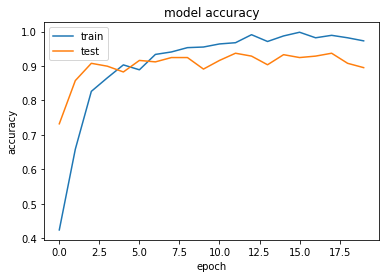

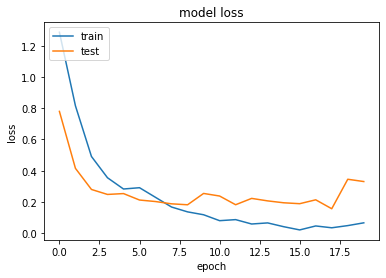

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Testing Model

Saving 057993000_1595219338-pizza-slices-marble-chopping-board_23-2147926088.jpg to 057993000_1595219338-pizza-slices-marble-chopping-board_23-2147926088.jpg
[0. 0. 1. 0.]
Pizza


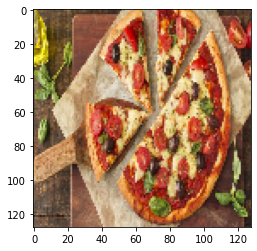

In [ ]:
label = ['Chocolate Cake', 'Pasta', 'Pizza', 'Salad']

%matplotlib inline
import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = '/content/dataset/' + fn
  img = image.load_img(path, target_size=(128, 128))
  x = image.img_to_array(img)
  plt.imshow(x/255.)
  x = np.expand_dims(x, axis=0)
  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  print(classes[0])
  print(label[np.argmax(classes[0])])

# Convert Model to Tflite

In [ ]:
RPS_SAVED_MODEL = "rps_saved_model"

tf.saved_model.save(model, RPS_SAVED_MODEL)

INFO:tensorflow:Assets written to: rps_saved_model/assets


INFO:tensorflow:Assets written to: rps_saved_model/assets


In [ ]:
%%bash -s $RPS_SAVED_MODEL
saved_model_cli show --dir $1 --tag_set serve --signature_def serving_default

The given SavedModel SignatureDef contains the following input(s):
  inputs['input_1'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 128, 128, 3)
      name: serving_default_input_1:0
The given SavedModel SignatureDef contains the following output(s):
  outputs['dense_1'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 4)
      name: StatefulPartitionedCall:0
Method name is: tensorflow/serving/predict


In [ ]:
loaded = tf.saved_model.load(RPS_SAVED_MODEL)

print(list(loaded.signatures.keys()))
infer = loaded.signatures["serving_default"]
print(infer.structured_input_signature)
print(infer.structured_outputs)

['serving_default']
((), {'input_1': TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name='input_1')})
{'dense_1': TensorSpec(shape=(None, 4), dtype=tf.float32, name='dense_1')}


In [ ]:
converter = tf.lite.TFLiteConverter.from_saved_model(RPS_SAVED_MODEL)
converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
tflite_model = converter.convert()

In [ ]:
tflite_model_file = 'converted_model.tflite'

with open(tflite_model_file, "wb") as f:
    f.write(tflite_model)

In [ ]:
try:
    from google.colab import files
    files.download('converted_model.tflite')
    files.download('labels.txt')
except:
    pass

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>